In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib notebook

# use CMU Serif
import matplotlib as mpl
import matplotlib.font_manager as font_manager
mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.transforms import Bbox

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os
import itertools

from utils import *

import sys
sys.path.append('/Users/theoares/lqcd/utilities')
from formattools import *
from plottools import *
from fittools import *

In [2]:
fpath = '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/nnpp/cl3_32_48_b6p1_m0p2450_99999/Z_gamma.h5'
F = h5py.File(fpath, 'r')
Lat = Lattice(32, 48)
a = 0.145  # fm, placeholder for now
ainv = hbarc / a
mpi = 0.8    # MeV, placeholder for now
k_list = F['momenta'][()]
mom_list = np.array([Lat.to_linear_momentum(k, datatype=np.float64) for k in k_list])
mu_list = np.array([get_energy_scale(q, a, Lat) for q in k_list])
apsq_list = np.array([square(k) for k in mom_list])
Zq = np.real(F['Zq'][()])
n_momenta, n_boot = Zq.shape[0], Zq.shape[1]
ZV = np.real(F['ZV'][()])
ZA = np.real(F['ZA'][()])
Z = np.zeros((5, 5, n_momenta, n_boot), dtype = np.float64)
for i, j in itertools.product(range(5), repeat = 2):
    key = 'Z' + str(i + 1) + str(j + 1)
    Z[i, j] = np.real(F[key][()])
ZbyZVsq = np.einsum('ijqb,qb->ijqb', Z, 1 / (ZV ** 2))

### Plot and determine a value for RCs at each lattice spacing

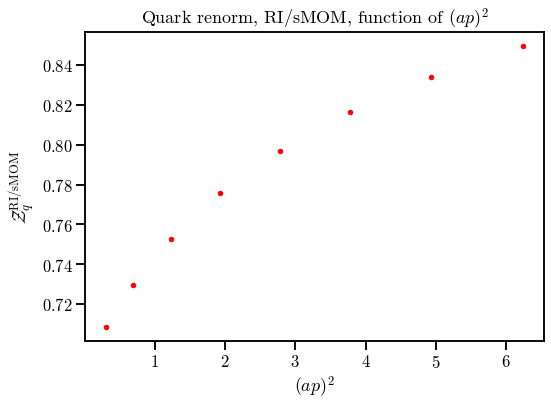

In [3]:
# Zq((ap)^2)
with sns.plotting_context('talk'):
    Zq_mu = np.mean(Zq, axis = 1)
    Zq_sigma = np.std(Zq, axis = 1, ddof = 1)
    plt.figure(figsize = (8, 6))
    plt.errorbar(apsq_list, Zq_mu, Zq_sigma, fmt = '.', c = 'r')
    plt.xlabel('$(ap)^2$', fontsize = 18)
    plt.ylabel('$\mathcal{Z}_q^\mathrm{RI/sMOM}$', fontsize = 18)
    plt.title('Quark renorm, RI/sMOM, function of $(ap)^2$')
    # plt.legend()
    plt.tight_layout()
    plt.show()

In [4]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/writeup_plots/Zq.pdf')

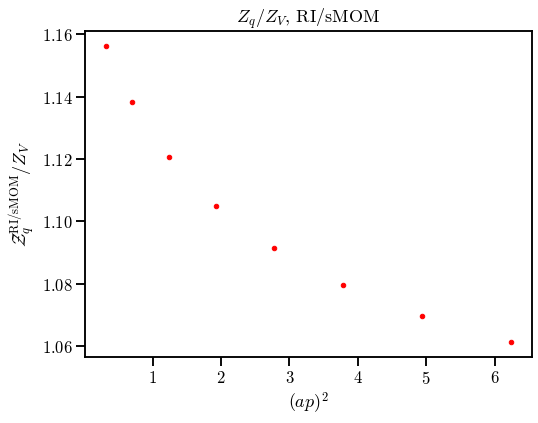

In [5]:
# Zq (μ^2)
ZqbyZV = Zq / ZV
ZqbyZV_mu = np.mean(ZqbyZV, axis = 1)
ZqbyZV_sigma = np.std(ZqbyZV, axis = 1, ddof = 1)
with sns.plotting_context('talk'):
    plt.figure(figsize = (8, 6))
    plt.errorbar(apsq_list, ZqbyZV_mu, ZqbyZV_sigma, fmt = '.', c = 'r')
    plt.xlabel('$(ap)^2$', fontsize = 18)
    plt.ylabel('$\mathcal{Z}_q^\mathrm{RI/sMOM} / Z_V$', fontsize = 18)
    plt.title('$Z_q / Z_V$, RI/sMOM')
    plt.show()

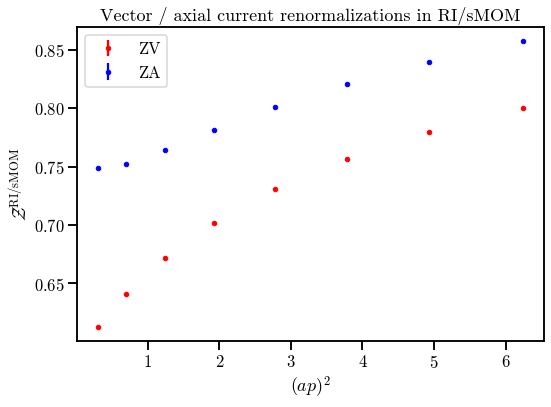

In [6]:
# ZV and ZA
ZV_mu = np.mean(ZV, axis = 1)
ZV_sigma = np.std(ZV, axis = 1, ddof = 1)
ZA_mu = np.mean(ZA, axis = 1)
ZA_sigma = np.std(ZA, axis = 1, ddof = 1)
with sns.plotting_context('talk'):
    plt.figure(figsize = (8, 6))
    plt.errorbar(apsq_list, ZV_mu, ZV_sigma, fmt = '.', c = 'r', label = 'ZV')
    plt.errorbar(apsq_list, ZA_mu, ZA_sigma, fmt = '.', c = 'b', label = 'ZA')
    # plt.ylim((0.6, 1.8))
    # plt.xlim((0, 5.5))
    plt.xlabel('$(ap)^2$', fontsize = 18)
    plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
    plt.title('Vector / axial current renormalizations in RI/sMOM')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [7]:
def plot_RCs(x_list, labels, colors, ZVsq = False):
    plot_title = '$Z_{ij} / Z_V^2$ operator renormalization in RI/sMOM' if ZVsq else \
                        '$Z_{ij}$ operator renormalization in RI/sMOM'
    y_label = '$Z_{ij} / Z_V^2$' if ZVsq else '$Z_{ij}$'
    x_mu = [np.mean(x, axis = 1) for x in x_list]
    x_sigma = [np.std(x, axis = 1, ddof = 1) for x in x_list]
    with sns.plotting_context('talk'):
        plt.figure(figsize = (10, 6))
        for ii in range(len(x_list)):
            plt.errorbar(apsq_list, x_mu[ii], x_sigma[ii], fmt = '.', c = colors[ii], \
                         label = labels[ii])
            plt.xlabel('$(ap)^2$', fontsize = 18)
            plt.ylabel(y_label, fontsize = 18)
            plt.title(plot_title)
        plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.tight_layout()
        plt.show()

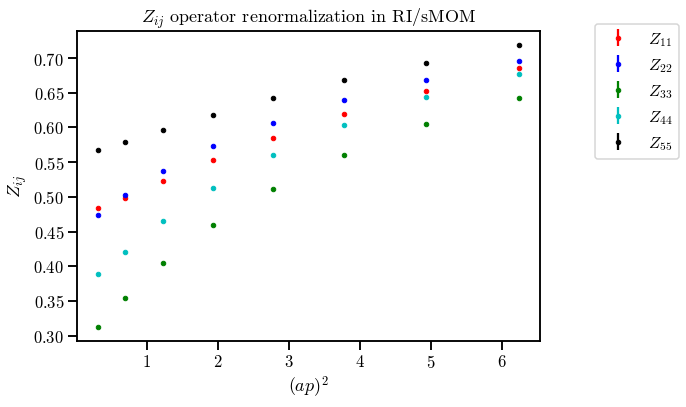

In [8]:
# Diagonal RCs
plot_RCs([Z[i, i] for i in range(5)], ['$Z_{'+str(i+1)+str(i+1) + '}$' for i in range(5)], ['r', 'b', 'g', 'c', 'k'])

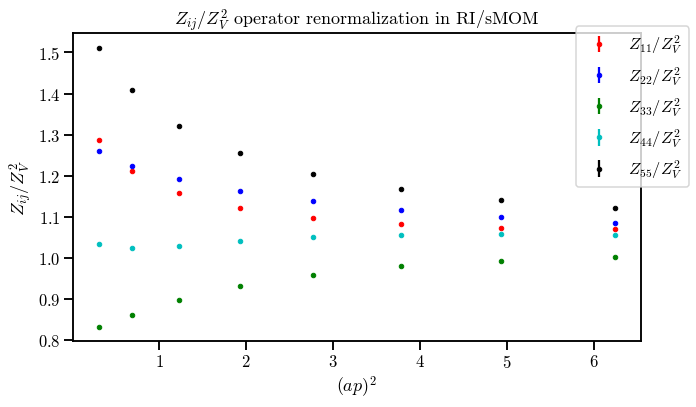

In [9]:
# Diagonal RCs / ZV^2
plot_RCs([ZbyZVsq[i, i] for i in range(5)], ['$Z_{' + str(i + 1) + str(i + 1) + '}/Z_V^2$' for i in range(5)], \
         ['r', 'b', 'g', 'c', 'k'], ZVsq = True)

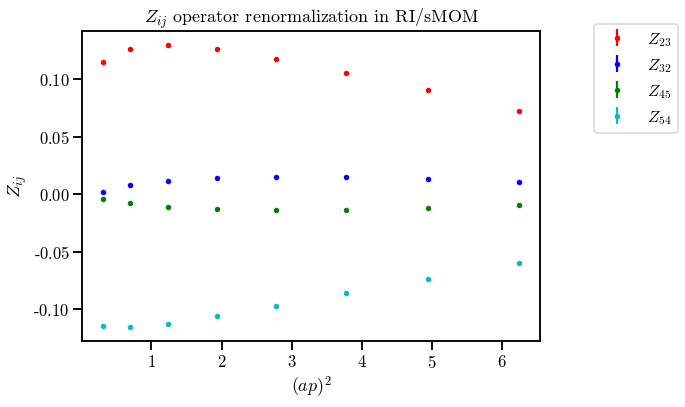

In [10]:
# Off diagonal elements allowed by chiral mixing
mix = [[1, 2], [2, 1], [3, 4], [4, 3]]
plot_RCs([Z[m[0], m[1]] for m in mix], ['$Z_{' + str(m[0] + 1) + str(m[1]+1)+'}$' for m in mix], ['r', 'b', 'g', 'c'])

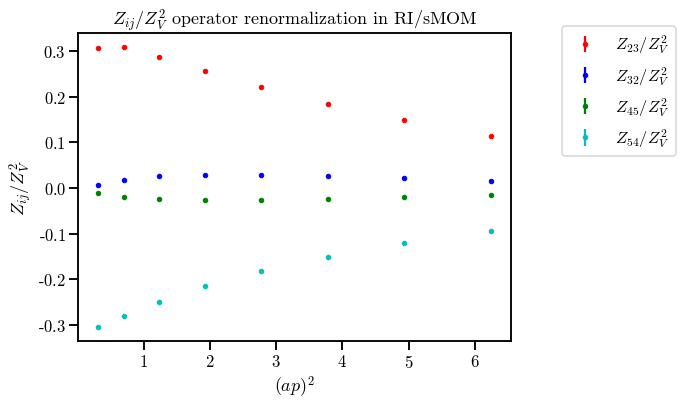

In [11]:
# Off diagonal elements allowed by chiral mixing
mix = [[1, 2], [2, 1], [3, 4], [4, 3]]
plot_RCs([ZbyZVsq[m[0], m[1]] for m in mix], ['$Z_{' + str(m[0] + 1) + str(m[1] + 1) + '} / Z_V^2$' for m in mix], \
         ['r', 'b', 'g', 'c'], ZVsq = True)

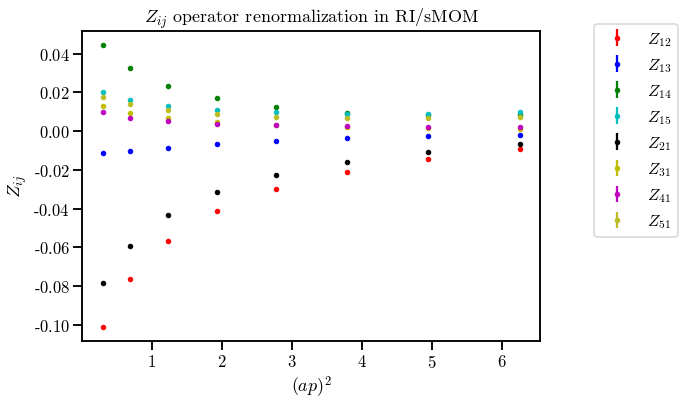

In [12]:
# Plot Zij for half the indices not allowed by chiral mixing
unmix1 = [[0, 1], [0, 2], [0, 3], [0, 4], [1, 0], [2, 0], [3, 0], [4, 0]]
plot_RCs([Z[m[0], m[1]] for m in unmix1], ['$Z_{' + str(m[0] + 1) + str(m[1] + 1) + '}$' for m in unmix1], \
         ['r', 'b', 'g', 'c', 'k', 'y', 'm', 'tab:olive'])

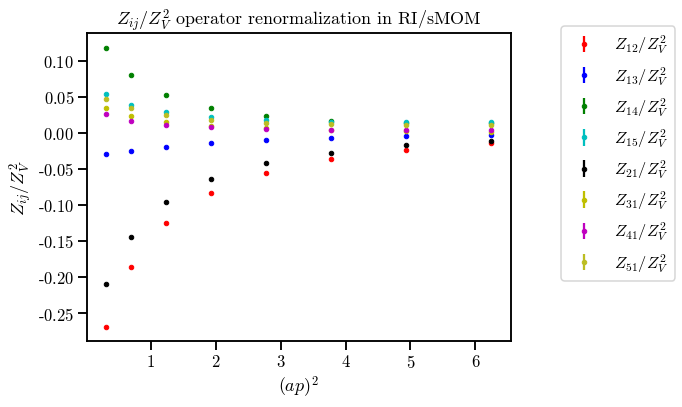

In [13]:
# Plot Zij / ZV^2 for half the indices not allowed by chiral mixing
plot_RCs([ZbyZVsq[m[0], m[1]] for m in unmix1], ['$Z_{' + str(m[0] + 1) + str(m[1]+1)+'} / Z_V^2$' for m in unmix1], \
         ['r', 'b', 'g', 'c', 'k', 'y', 'm', 'tab:olive'], ZVsq = True)

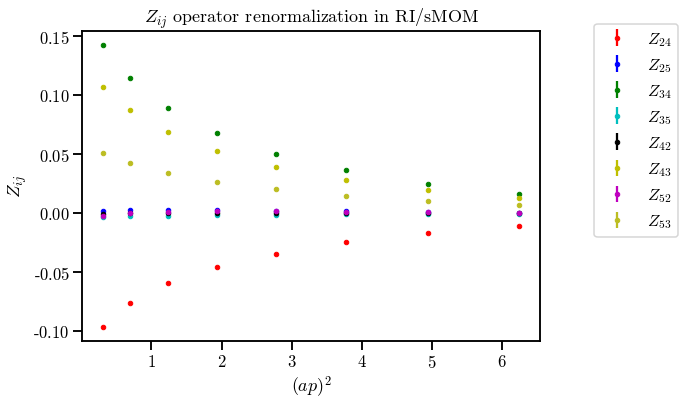

In [14]:
# Plot Zij for half the indices not allowed by chiral mixing
unmix2 = [[1, 3], [1, 4], [2, 3], [2, 4], [3, 1], [3, 2], [4, 1], [4, 2]]
plot_RCs([Z[m[0], m[1]] for m in unmix2], ['$Z_{' + str(m[0] + 1) + str(m[1] + 1) + '}$' for m in unmix2], \
         ['r', 'b', 'g', 'c', 'k', 'y', 'm', 'tab:olive'])

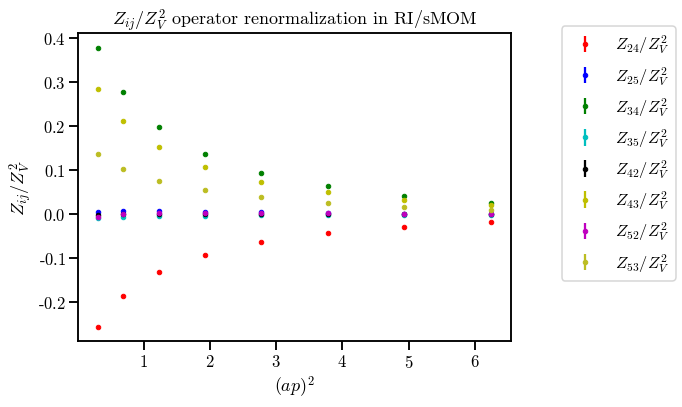

In [15]:
# Plot Zij / ZV^2 for half the indices not allowed by chiral mixing
plot_RCs([ZbyZVsq[m[0], m[1]] for m in unmix2], ['$Z_{' + str(m[0]+1)+str(m[1]+1) + '} / Z_V^2$' for m in unmix2], \
         ['r', 'b', 'g', 'c', 'k', 'y', 'm', 'tab:olive'], ZVsq = True)

## Fit $Z_q, Z_V, Z_A$

In [16]:
lam_list = np.arange(0, 1, 0.1)
def fit_data_model(subset_idxs, Z, model, lam = 1):
    """
    Fits data Z to an arbitrary model by minimizing the correlated chi^2. 
    lam is the parameter for linear shrinkage, i.e. lam = 0 is the uncorrelated covariance, and lam = 1 is the 
    original covariance. 
    """
    fitter = BootstrapFitter(apsq_list[subset_idxs], np.einsum('kb->bk', Z[subset_idxs]), model)
    print('Original covariance: ' + str(fitter.covar))
    fitter.shrink_covar(lam)
    print('Shrunk covariance: ' + str(fitter.covar))
    fit_out = fitter.fit()
    print('Best fit coeffs: ' + str(fit_out[0]))
    print('chi^2 / dof: ' + str(fit_out[1] / fit_out[2]))
    return fit_out

def plot_fit_out(Z, fout, model, label, subset = list(range(len(apsq_list)))):
    #x_range = [0., 3.]
    buffer = 0.2    # extra space to add in plot
    x_range = [apsq_list[subset[0]] - buffer, apsq_list[subset[-1]] + buffer]
    x_fit_b = np.linspace(x_range[0], x_range[1])
    fx_fit_b = np.array([model.F(fout[0])(xb) for xb in x_fit_b], dtype = np.float64)
    Z_mu = np.mean(Z, axis = 1)
    Z_sigma = np.std(Z, axis = 1, ddof = 1)
    with sns.plotting_context('talk'):
        plt.figure(figsize = (10, 6))
        plt.errorbar(apsq_list, Z_mu, Z_sigma, c = 'b', fmt = '.')
        plt.plot(x_fit_b, fx_fit_b, c = 'r')
        plt.xlabel('$(ap)^2$')
        plt.ylabel(label)
        plt.title('Fits for ' + label)
        plt.show()

In [17]:
# # Use a more arbitrary model
# subset_idxs = [2, 3, 4, 5, 6, 7]
# def model_ZV(params):
#     def model(apsq):
#         return params[0] * (apsq ** 0) + params[1] * (apsq ** 1) + params[2] * (apsq ** 2) + params[3] * np.log(apsq)
#     return model
# m_ZV = Model(model_ZV, 4)
# ZV_fout = fit_data_model(subset_idxs, ZV, m_ZV, lam = 0)
# plot_fitmodel_out(ZV, ZV_fout, m_ZV, label = '$Z_V$', subset = subset_idxs)

Original covariance: [[1.4138963e-08 1.2346763e-08 1.0022843e-08 8.1496498e-09 6.7785324e-09
  5.6831579e-09 4.7521493e-09 3.9922443e-09]
 [1.2346763e-08 1.1737580e-08 1.0031940e-08 8.3922291e-09 7.0963537e-09
  6.0080323e-09 5.0592779e-09 4.2573083e-09]
 [1.0022843e-08 1.0031940e-08 8.9410825e-09 7.6779587e-09 6.5933197e-09
  5.6509117e-09 4.8250994e-09 4.1161807e-09]
 [8.1496498e-09 8.3922291e-09 7.6779587e-09 6.7409935e-09 5.8935803e-09
  5.1307634e-09 4.4443271e-09 3.8305639e-09]
 [6.7785324e-09 7.0963537e-09 6.5933197e-09 5.8935803e-09 5.2495119e-09
  4.6453099e-09 4.0720671e-09 3.5277734e-09]
 [5.6831579e-09 6.0080323e-09 5.6509117e-09 5.1307634e-09 4.6453099e-09
  4.1702530e-09 3.6942380e-09 3.2162522e-09]
 [4.7521493e-09 5.0592779e-09 4.8250994e-09 4.4443271e-09 4.0720671e-09
  3.6942380e-09 3.3035568e-09 2.8965566e-09]
 [3.9922443e-09 4.2573083e-09 4.1161807e-09 3.8305639e-09 3.5277734e-09
  3.2162522e-09 2.8965566e-09 2.5613600e-09]]
Shrunk covariance: [[1.4138963e-08 6.17338

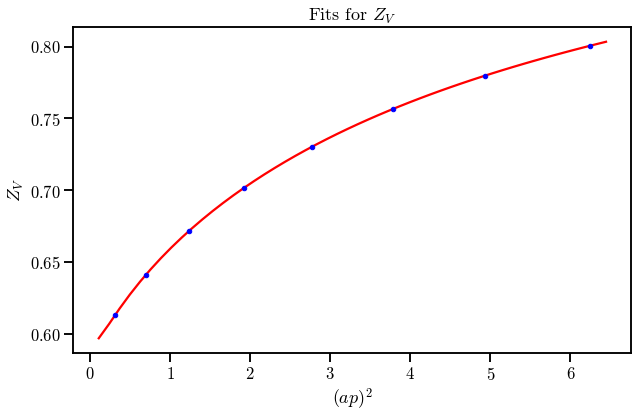

In [18]:
# Use a more arbitrary model
subset_idxs = [0, 1, 2, 3, 4, 5, 6, 7]
def model_ZV(params):
    def model(apsq):
        return params[0] * (apsq ** 0) + params[1] * (apsq ** 1) + params[2] * (apsq ** 2) + params[3] / apsq + params[4] * np.log(apsq) * apsq
    return model
m_ZV = Model(model_ZV, 5)
ZV_fout = fit_data_model(subset_idxs, ZV, m_ZV, lam = 0.5)
# ZV_fout = fit_data_model(subset_idxs, ZV, m_ZV, lam = 0.)
plot_fit_out(ZV, ZV_fout, m_ZV, label = '$Z_V$', subset = subset_idxs)

Original covariance: [[7.20987217e-08 4.64601264e-08 3.04985193e-08 2.10944240e-08
  1.58063180e-08 1.21348549e-08 8.99325148e-09 6.46851195e-09]
 [4.64601264e-08 3.16845536e-08 2.15676490e-08 1.51470285e-08
  1.13822685e-08 8.80042705e-09 6.64077771e-09 4.86973262e-09]
 [3.04985193e-08 2.15676490e-08 1.51590172e-08 1.09167786e-08
  8.35271585e-09 6.58490906e-09 5.11635090e-09 3.89965837e-09]
 [2.10944240e-08 1.51470285e-08 1.09167786e-08 8.14550116e-09
  6.45652154e-09 5.26278576e-09 4.24414326e-09 3.37286421e-09]
 [1.58063180e-08 1.13822685e-08 8.35271585e-09 6.45652154e-09
  5.31126743e-09 4.47138282e-09 3.71789755e-09 3.04275538e-09]
 [1.21348549e-08 8.80042705e-09 6.58490906e-09 5.26278576e-09
  4.47138282e-09 3.86675980e-09 3.29325767e-09 2.75269096e-09]
 [8.99325148e-09 6.64077771e-09 5.11635090e-09 4.24414326e-09
  3.71789755e-09 3.29325767e-09 2.86933433e-09 2.45064036e-09]
 [6.46851195e-09 4.86973262e-09 3.89965837e-09 3.37286421e-09
  3.04275538e-09 2.75269096e-09 2.45064036

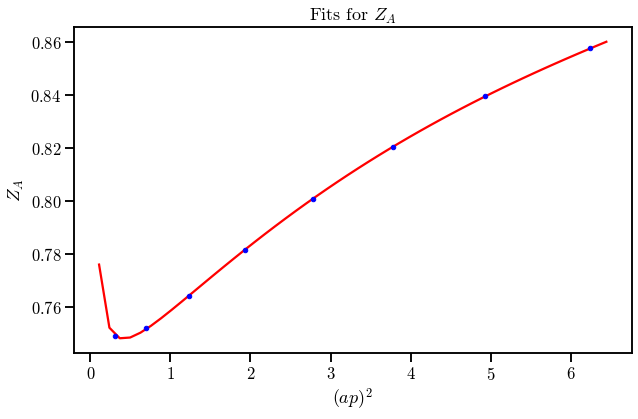

In [19]:
# Use a more arbitrary model
# subset_idxs = [0, 1, 2, 3, 4, 5]
# def model_ZA(params):
#     def model(apsq):
#         return params[0] * (apsq ** 0) + params[1] * (apsq ** 1) + params[2] * (apsq ** 2) + params[3] / apsq
#     return model
subset_idxs = [0, 1, 2, 3, 4, 5, 6, 7]
def model_ZA(params):
    def model(apsq):
        return params[0] * (apsq ** 0) + params[1] * (apsq ** 1) + params[2] * (apsq ** 2) + params[3] / apsq + params[4] * (apsq ** 3)
    return model
m_ZA = Model(model_ZA, 5)
ZA_fout = fit_data_model(subset_idxs, ZA, m_ZA, lam = 0.2)
plot_fit_out(ZA, ZA_fout, m_ZA, label = '$Z_A$', subset = subset_idxs)

Original covariance: [[3.5039164e-08 2.6759579e-08 1.9674108e-08 1.4508229e-08 1.0810712e-08
  8.1209022e-09 6.0400658e-09 4.4051682e-09]
 [2.6759579e-08 2.1494490e-08 1.6414408e-08 1.2445851e-08 9.5136867e-09
  7.3762050e-09 5.7259384e-09 4.3926560e-09]
 [1.9674108e-08 1.6414408e-08 1.2953629e-08 1.0116540e-08 7.9604785e-09
  6.3681602e-09 5.1197029e-09 4.0716954e-09]
 [1.4508229e-08 1.2445851e-08 1.0116540e-08 8.1638740e-09 6.6359078e-09
  5.4743663e-09 4.5300306e-09 3.6936501e-09]
 [1.0810712e-08 9.5136867e-09 7.9604785e-09 6.6359078e-09 5.5641167e-09
  4.7197672e-09 4.0011847e-09 3.3268643e-09]
 [8.1209022e-09 7.3762050e-09 6.3681602e-09 5.4743663e-09 4.7197672e-09
  4.1049382e-09 3.5569028e-09 3.0118521e-09]
 [6.0400658e-09 5.7259384e-09 5.1197029e-09 4.5300306e-09 4.0011847e-09
  3.5569028e-09 3.1436607e-09 2.7082865e-09]
 [4.4051682e-09 4.3926560e-09 4.0716954e-09 3.6936501e-09 3.3268643e-09
  3.0118521e-09 2.7082865e-09 2.3708697e-09]]
Shrunk covariance: [[3.5039164e-08 0.00000

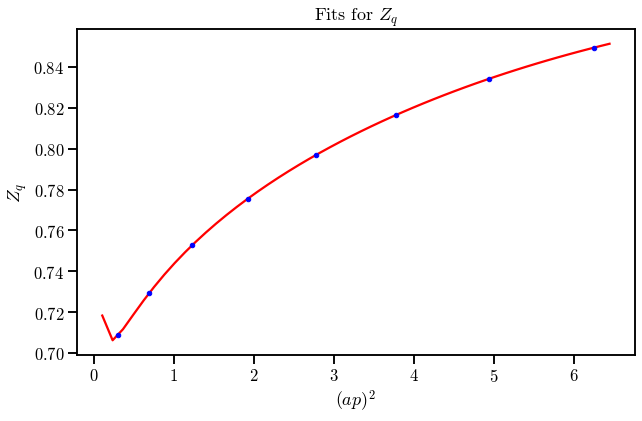

In [20]:
subset_idxs = [0, 1, 2, 3, 4, 5, 6, 7]
def model_Zq(params):
    def model(apsq):
        return params[0] * (apsq ** 0) + params[1] * (apsq ** 1) + params[2] * (apsq ** 2) + params[3] / apsq + params[4] * np.log(apsq) + params[5] * apsq * np.log(apsq)
    return model
m_Zq = Model(model_Zq, 6)
Zq_fout = fit_data_model(subset_idxs, Zq, m_Zq, lam = 0.)
plot_fit_out(Zq, Zq_fout, m_Zq, label = '$Z_q$', subset = subset_idxs)

Original covariance: [[ 1.74583796e-08  1.01917585e-08  6.99843872e-09  4.82222706e-09
   2.66291900e-09  1.11284915e-09  3.23665261e-10 -4.72351411e-12]
 [ 1.01917585e-08  6.19984686e-09  4.53550264e-09  3.33478711e-09
   2.04952455e-09  1.07534237e-09  5.42672796e-10  2.97815134e-10]
 [ 6.99843872e-09  4.53550264e-09  3.65565112e-09  2.91733659e-09
   2.00480987e-09  1.25879840e-09  8.14591117e-10  5.88664339e-10]
 [ 4.82222706e-09  3.33478711e-09  2.91733659e-09  2.48186405e-09
   1.83337279e-09  1.25595156e-09  8.87004137e-10  6.86933566e-10]
 [ 2.66291900e-09  2.04952455e-09  2.00480987e-09  1.83337279e-09
   1.45648960e-09  1.07797282e-09  8.13696999e-10  6.59240107e-10]
 [ 1.11284915e-09  1.07534237e-09  1.25879840e-09  1.25595156e-09
   1.07797282e-09  8.62770855e-10  6.94116431e-10  5.86046656e-10]
 [ 3.23665261e-10  5.42672796e-10  8.14591117e-10  8.87004137e-10
   8.13696999e-10  6.94116431e-10  5.87974114e-10  5.13646681e-10]
 [-4.72351411e-12  2.97815134e-10  5.88664339e-1

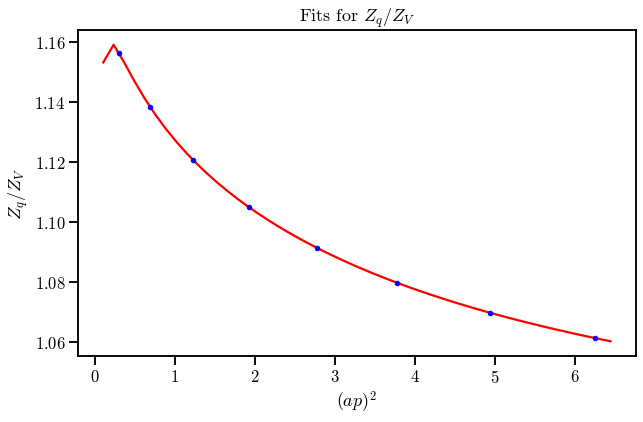

In [21]:
subset_idxs = [0, 1, 2, 3, 4, 5, 6, 7]
def model_ZqZV(params):
    def model(apsq):
        return params[0] * (apsq ** 0) + params[1] * (apsq ** 1) + params[2] * (apsq ** 2) + params[3] / apsq + params[4] * np.log(apsq) + params[5] * (apsq ** 3) #* apsq * np.log(apsq)
    return model
m_ZqZV = Model(model_ZqZV, 6)
ZqZV_fout = fit_data_model(subset_idxs, ZqbyZV, m_ZqZV, lam = 0.)
plot_fit_out(ZqbyZV, ZqZV_fout, m_ZqZV, label = '$Z_q / Z_V$', subset = subset_idxs)

## Fit $Z_{nm} / Z_V^2$

Original covariance: [[1.23387379e-07 8.71380460e-08 5.74065147e-08 3.50668873e-08
  2.13710966e-08 1.36712481e-08 8.91537142e-09 5.58417500e-09]
 [8.71380460e-08 6.71110932e-08 4.64430744e-08 2.86008984e-08
  1.73396669e-08 1.12627191e-08 7.53689896e-09 4.85123412e-09]
 [5.74065147e-08 4.64430744e-08 3.32832612e-08 2.07919438e-08
  1.25896831e-08 8.16328658e-09 5.49069361e-09 3.61224824e-09]
 [3.50668873e-08 2.86008984e-08 2.07919438e-08 1.31737853e-08
  8.02300900e-09 5.17589904e-09 3.46200082e-09 2.30240308e-09]
 [2.13710966e-08 1.73396669e-08 1.25896831e-08 8.02300900e-09
  4.93793872e-09 3.20579505e-09 2.14372940e-09 1.42394493e-09]
 [1.36712481e-08 1.12627191e-08 8.16328658e-09 5.17589904e-09
  3.20579505e-09 2.11980727e-09 1.43637422e-09 9.49355032e-10]
 [8.91537142e-09 7.53689896e-09 5.49069361e-09 3.46200082e-09
  2.14372940e-09 1.43637422e-09 9.85991319e-10 6.51623638e-10]
 [5.58417500e-09 4.85123412e-09 3.61224824e-09 2.30240308e-09
  1.42394493e-09 9.49355032e-10 6.51623638

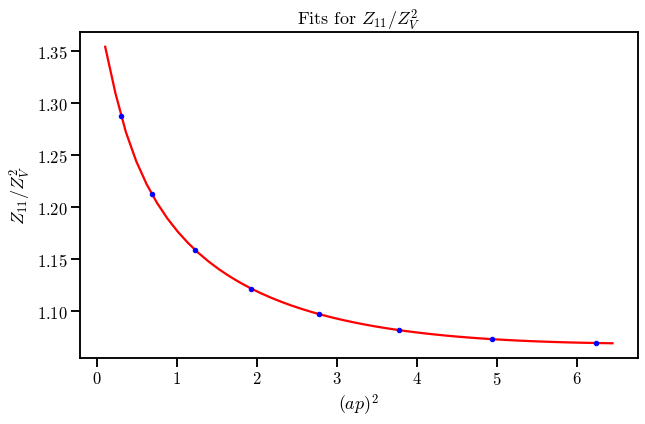

In [22]:
subset_idxs = [0, 1, 2, 3, 4, 5, 6, 7]
def model_Z11ZVsq(params):
    def model(apsq):
        return params[0] * (apsq ** 0) + params[1] * (apsq ** 1) + params[2] * (apsq ** 2) + params[3] / apsq + params[4] * np.log(apsq) + params[5] * (apsq ** 3)
    return model
m11ZVsq = Model(model_Z11ZVsq, 6)
Z11ZVsq_fout = fit_data_model(subset_idxs, ZbyZVsq[0, 0], m11ZVsq, lam = 0.)
plot_fit_out(ZbyZVsq[0, 0], Z11ZVsq_fout, m11ZVsq, label = '$Z_{11} / Z_V^2$', subset = subset_idxs)

Original covariance: [[6.96210168e-08 4.79886339e-08 3.13838002e-08 1.84216546e-08
  9.53393510e-09 4.47691527e-09 1.96278980e-09 7.11576424e-10]
 [4.79886339e-08 3.69000025e-08 2.65879422e-08 1.65593549e-08
  9.24321665e-09 5.14206682e-09 2.99740276e-09 1.77059718e-09]
 [3.13838002e-08 2.65879422e-08 2.10486236e-08 1.39517023e-08
  8.27327567e-09 5.01944254e-09 3.25274260e-09 2.19592633e-09]
 [1.84216546e-08 1.65593549e-08 1.39517023e-08 9.71948277e-09
  6.02150434e-09 3.80076935e-09 2.55442249e-09 1.81272565e-09]
 [9.53393510e-09 9.24321665e-09 8.27327567e-09 6.02150434e-09
  3.88486417e-09 2.54323393e-09 1.75451107e-09 1.27609182e-09]
 [4.47691527e-09 5.14206682e-09 5.01944254e-09 3.80076935e-09
  2.54323393e-09 1.74188707e-09 1.24591469e-09 9.25448976e-10]
 [1.96278980e-09 2.99740276e-09 3.25274260e-09 2.55442249e-09
  1.75451107e-09 1.24591469e-09 9.22873304e-10 7.03885558e-10]
 [7.11576424e-10 1.77059718e-09 2.19592633e-09 1.81272565e-09
  1.27609182e-09 9.25448976e-10 7.03885558

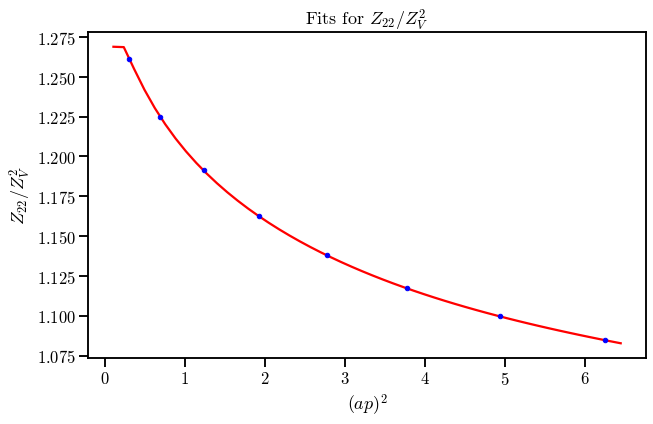

In [23]:
subset_idxs = [0, 1, 2, 3, 4, 5, 6, 7]
def model_Z22ZVsq(params):
    def model(apsq):
        return params[0] * (apsq ** 0) + params[1] * (apsq ** 1) + params[2] * (apsq ** 2) + params[3] / apsq + params[4] * np.log(apsq) + params[5] * (apsq ** 3)
    return model
m22ZVsq = Model(model_Z22ZVsq, 6)
Z22ZVsq_fout = fit_data_model(subset_idxs, ZbyZVsq[1, 1], m22ZVsq, lam = 0.)
plot_fit_out(ZbyZVsq[1, 1], Z22ZVsq_fout, m22ZVsq, label = '$Z_{22} / Z_V^2$', subset = subset_idxs)

Original covariance: [[ 3.77253260e-08  2.47293634e-08  1.18871932e-08  4.23485702e-09
   9.68541917e-10  1.22409749e-10 -6.59246020e-11 -1.89743765e-10]
 [ 2.47293634e-08  1.88480308e-08  1.17793016e-08  6.88044947e-09
   4.45888610e-09  3.42670212e-09  2.66549390e-09  1.89888429e-09]
 [ 1.18871932e-08  1.17793016e-08  1.02391454e-08  8.37652318e-09
   7.03936006e-09  5.95194619e-09  4.73670581e-09  3.49520318e-09]
 [ 4.23485702e-09  6.88044947e-09  8.37652318e-09  8.50737222e-09
   8.05590730e-09  7.11072739e-09  5.74799460e-09  4.31721290e-09]
 [ 9.68541917e-10  4.45888610e-09  7.03936006e-09  8.05590730e-09
   8.09793650e-09  7.33178843e-09  6.00693849e-09  4.56863902e-09]
 [ 1.22409749e-10  3.42670212e-09  5.95194619e-09  7.11072739e-09
   7.33178843e-09  6.73868609e-09  5.58206926e-09  4.28529915e-09]
 [-6.59246020e-11  2.66549390e-09  4.73670581e-09  5.74799460e-09
   6.00693849e-09  5.58206926e-09  4.66984766e-09  3.61527902e-09]
 [-1.89743765e-10  1.89888429e-09  3.49520318e-0

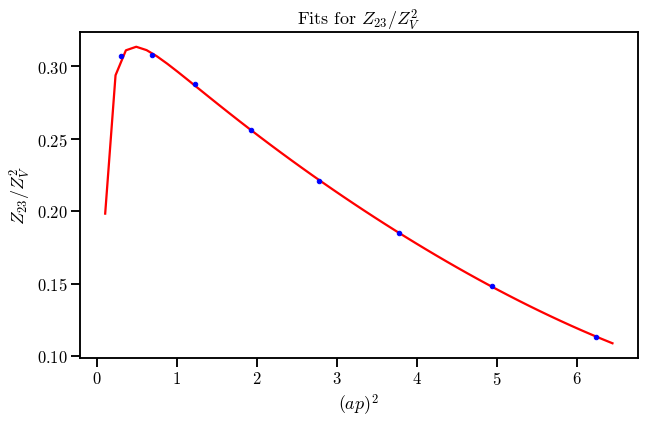

In [24]:
subset_idxs = [0, 1, 2, 3, 4, 5, 6, 7]
def model_Z23ZVsq(params):
    def model(apsq):
        return params[0] * (apsq ** 0) + params[1] * (apsq ** 1) + params[2] * (apsq ** 2) + params[3] / apsq + params[4] * np.log(apsq) + params[5] * (apsq * np.log(apsq)) + params[6] * (apsq ** 3)
    return model
m23ZVsq = Model(model_Z23ZVsq, 7)
Z23ZVsq_fout = fit_data_model(subset_idxs, ZbyZVsq[1, 2], m23ZVsq, lam = 0.)
plot_fit_out(ZbyZVsq[1, 2], Z23ZVsq_fout, m23ZVsq, label = '$Z_{23} / Z_V^2$', subset = subset_idxs)

In [25]:
# Shrinkage (linear vs nonlinear), thinning, SVD cuts
# cov = fitter.covar
# sigma = np.array([np.sqrt(cov[i, i]) for i in range(4)])
# corr = np.zeros((4, 4))
# for i, j in itertools.product(range(4), repeat = 2):
#     corr[i, j] = cov[i, j] / (sigma[i] * sigma[j])